## Ceate Dataset

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import csv

class StockDataset(Dataset):
    ''' Dataset for loading and preprocessing the dataset '''
    def __init__(self,
                 path,
                 mode='train'
              ):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 4:].astype(float)
        
        

        target = data[:, -1]
        data = data[:, list(range(22))]

        

        self.data = torch.FloatTensor(data)
        self.target = torch.LongTensor(target)


        # Normalize features
        self.data = \
            (self.data - self.data.mean(dim=0, keepdim=True)) \
            / self.data.std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        # print(f'Finished reading the {mode} set of Dataset ({len(self.data)} samples found, each dim = {self.dim})')

    def __getitem__(self, index):

        return self.data[index], self.target[index]

    def __len__(self):

        return len(self.data)


## Create Model

In [2]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.layer2 = nn.Linear(22, 256)
        self.layer2_bn=nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 128)
        self.layer3_bn=nn.BatchNorm1d(128)

        self.layer4 = nn.Linear(128, 64)
        self.layer4_bn=nn.BatchNorm1d(64)

        self.layer5 = nn.Linear(64, 32)
        self.layer5_bn=nn.BatchNorm1d(32)

        self.drop = nn.Dropout(0.5)

        self.out = nn.Linear(32, 3) 
        
        self.act_fn = nn.ReLU()
        

    def forward(self, x):

        x = self.layer2(x)
        x = self.layer2_bn(x)
        x = self.act_fn(x)
        x = self.drop(x)

        x = self.layer3(x)
        x = self.layer3_bn(x)
        x = self.act_fn(x)
        x = self.drop(x)
 
        x = self.layer4(x)
        x = self.layer4_bn(x)
        x = self.act_fn(x)
        x = self.drop(x)

        x = self.layer5(x)
        x = self.layer5_bn(x)
        x = self.act_fn(x)
        x = self.drop(x)

        x = self.out(x)

        
        return x

### Training Parameters

In [3]:

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score 
plt.ioff()
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# fix random seed for reproducibility
same_seeds(0)

# get device 
device = 'cpu'
print(f'DEVICE: {device}')

# training parameters
num_epoch = 100        # number of training epoch
BATCH_SIZE = 32
learning_rate = 0.001       # learning rate


def macro_precision(y_true, y_predict):
    hit_count = {0: 0, 1: 0, 2: 0}
    loss_count = 0
    for i, prediction in enumerate(y_predict):
        if y_true[i] == prediction:
            hit_count[prediction] += 1
        elif (y_true[i] == 0 and prediction == 2) or (y_true[i] == 2 and prediction == 0):
            loss_count += 1
    # r1 = hit_count[0]/y_true.count(0)
    # r2 = hit_count[1]/y_true.count(1)
    # r3 = hit_count[2]/y_true.count(2)

    if hit_count[0] == 0:
        p1 = 0
    else:
        p1 = hit_count[0]/y_predict.count(0)
    if hit_count[1] == 0:
        p2 = 0
    else:
        p2 = hit_count[1]/y_predict.count(1)
    if hit_count[2] == 0:
        p3 = 0
    else:
        p3 = hit_count[2]/y_predict.count(2)

    # f1 = 2 * p1 * r1 / (p1 + r1)
    # f2 = 2 * p2 * r2 / (p2 + r2)
    # f3 = 2 * p3 * r3 / (p3 + r3)
    
    # return (p1 + p2 + p3) / 3
    return hit_count[0] + hit_count[2] - loss_count

def plot_learning_curve(acc_record, title, y_label, i , d, limit_y = True):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_epoch = len(acc_record['train'])
    x = range(total_epoch)
    # x_2 = x_1[::len(acc_record['train']) // len(acc_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x, acc_record['train'], c='tab:red', label='train')
    plt.plot(x, acc_record['dev'], c='tab:cyan', label='dev')
    if limit_y:
        plt.ylim(0.0, 1.0)
    plt.xlabel('Training Epoch')
    plt.ylabel(y_label)
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.savefig(f'./models_300/fig/{y_label}_{i}_{d}d.png')
    plt.close()

DEVICE: cpu


## Training

In [4]:
error_list = []

for i in range(1, 356):
    print(f'Model {i}')
    for d in [10, 20, 30, 40, 60, 120]:
       
# for error in redo_list:
#         i, d = error
#         i = int(i)
#         d = int(d[:-1])
#         print(f'Model {i}_{d}d')
        early_stop_count = 0
        
        train_set = StockDataset(f'./data/training_data_300/training_data_{i}_{d}d.csv')
        val_set = StockDataset(f'./data/training_data_300/testing_data_{i}_{d}d.csv')
        train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True) #only shuffle the training data
        val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

        # the path where checkpoint saved
        model_path = f'./models_300/models/model_{i}_{d}d.ckpt'

        # create model, define a loss function, and optimizer
        model = Classifier().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training

        best_acc = 0.0
        best_macro_precision = 0.0

        acc_record = {'train': [], 'dev': []}
        macro_f1_record = {'train': [], 'dev': []}
        macro_precision_score_record = {'train': [], 'dev': []}

        # init accuracy
        train_acc = 0.0
        val_acc = 0.0

        train_labels = []
        train_predictions = []
        val_labels = []
        val_predictions = []
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, val_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() 
                for y in val_pred.cpu().numpy():
                    val_predictions.append(y)

                for y in labels.cpu().numpy():
                    val_labels.append(y)
            
            for data in train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs) 
                _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
                train_acc += (train_pred.cpu() == labels.cpu()).sum().item() 
                for y in train_pred.cpu().numpy():
                    train_predictions.append(y)

                for y in labels.cpu().numpy():
                    train_labels.append(y)

            acc_record['dev'].append(val_acc/len(val_set))
            acc_record['train'].append(train_acc/len(train_set))
            macro_f1_record['dev'].append(f1_score(val_labels, val_predictions, average='macro'))
            macro_f1_record['train'].append(f1_score(train_labels, train_predictions, average='macro'))
            macro_precision_score_record['dev'].append(macro_precision(val_labels, val_predictions))
            macro_precision_score_record['train'].append(macro_precision(train_labels, train_predictions))
            torch.save(model.state_dict(), model_path)

        # start training
        for epoch in range(num_epoch):
        
            train_acc = 0.0
            train_loss = 0.0
            val_acc = 0.0
            val_loss = 0.0

            train_labels = []
            train_predictions = []
            val_labels = []
            val_predictions = []

            # training
            model.train() # set the model to training mode
            for data in train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad() 
                outputs = model(inputs) 
                batch_loss = criterion(outputs, labels)
                _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
                batch_loss.backward() # compute gradient
                optimizer.step() # update model with optimizer

                train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
                train_loss += batch_loss.item()
                for y in train_pred.cpu().numpy():
                    train_predictions.append(y)

                for y in labels.cpu().numpy():
                    train_labels.append(y)

            
            acc_record['train'].append(train_acc/len(train_set))

            train_f1 = f1_score(train_labels, train_predictions, average='macro')
            macro_f1_record['train'].append(train_f1)

            train_weighted_precision = macro_precision(train_labels, train_predictions)
            macro_precision_score_record['train'].append(train_weighted_precision)

            # validation

            model.eval() # set the model to evaluation mode
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    batch_loss = criterion(outputs, labels) 
                    _, val_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
                
                    val_acc += (val_pred.cpu() == labels.cpu()).sum().item() 
                    val_loss += batch_loss.item()
                    for y in val_pred.cpu().numpy():
                        val_predictions.append(y)

                    for y in labels.cpu().numpy():
                        val_labels.append(y)


                acc_record['dev'].append(val_acc/len(val_set))

                val_f1 = f1_score(val_labels, val_predictions, average='macro')
                macro_f1_record['dev'].append(val_f1)

                val_weighted_precision = macro_precision(val_labels, val_predictions)
                macro_precision_score_record['dev'].append(val_weighted_precision)


                # if the model improves, save a checkpoint at this epoch
                if val_weighted_precision > best_macro_precision:
                    best_macro_precision = val_weighted_precision
                    torch.save(model.state_dict(), model_path)
                    # print('[{:03d}/{:03d}] Train Acc: {:3.6f} F1: {:.3f} wP: {:.3f} Loss: {:3.6f} | \
                    # Val Acc: {:3.6f} F1: {:.3f} wP: {:.3f} loss: {:3.6f}'
                        # .format(epoch + 1, num_epoch, train_acc/len(train_set), train_f1, train_weighted_precision, train_loss/len(train_loader), 
                        #                             val_acc/len(val_set), val_f1, val_weighted_precision, val_loss/len(val_loader)))
                    # print('saving model with Val Acc {:.3f}'.format(best_acc/len(val_set)))
                    # print('saving model with Val Precision {:.3f}'.format(best_macro_precision))
                    early_stop_count = 0
                else:
                    early_stop_count += 1
        
            # if early_stop_count >= 20:
            #     break

        plot_learning_curve(acc_record, 'deep model', 'Accuracy', i, d)
        plot_learning_curve(macro_precision_score_record, 'deep model', 'Macro Precision', i, d, limit_y=False)
        plot_learning_curve(macro_f1_record, 'deep model', 'Macro F1 Score', i, d)
            


Model 1
Model 2
Model 3
Model 4
Model 5
Model 6
Model 7
Model 8
Model 9
Model 10
Model 11
Model 12
Model 13
Model 14
Model 15
Model 16
Model 17
Model 18
Model 19
Model 20
Model 21
Model 22
Model 23
Model 24
Model 25
Model 26
Model 27
Model 28
Model 29
Model 30
Model 31
Model 32
Model 33
Model 34
Model 35
Model 36
Model 37
Model 38
Model 39
Model 40
Model 41
Model 42
Model 43
Model 44
Model 45
Model 46
Model 47
Model 48
Model 49
Model 50
Model 51
Model 52
Model 53
Model 54
Model 55
Model 56
Model 57
Model 58
Model 59
Model 60
Model 61
Model 62
Model 63
Model 64
Model 65
Model 66
Model 67
Model 68
Model 69
Model 70
Model 71
Model 72
Model 73
Model 74
Model 75
Model 76
Model 77
Model 78
Model 79
Model 80
Model 81
Model 82
Model 83
Model 84
Model 85
Model 86
Model 87
Model 88
Model 89
Model 90
Model 91
Model 92
Model 93
Model 94
Model 95
Model 96
Model 97
Model 98
Model 99
Model 100
Model 101
Model 102
Model 103
Model 104
Model 105
Model 106
Model 107
Model 108
Model 109
Model 110
Model 11

In [5]:
error_list

[]

In [6]:
import json
    
with open("errors.json", "w") as outfile:
    json.dump(error_list, outfile)
with open('errors.json') as jsonfile:
    redo_list = json.load(jsonfile)    

## Testing

In [6]:

def plot_confusion_matrix(cm,
                          target_names,
                          model,
                          d,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    # plt.xlabel(f'Predicted label\naccuracy={accuracy}')
    plt.xlabel('Predicted label')
    plt.savefig(f'./models_300/performance/model_{model}_{d}d.png')
    plt.close()

## Average annualized return

In [7]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import csv
import json

with open('performance_300.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['model', 'd', 'acc', 'r1', 'r2', 'r3', 'p1', 'p2', 'p3', 'f1', 'f2', 'f3'])

with open('trend_params_300.json') as jsonfile:
    code_para_map = json.load(jsonfile)

with open('codes_300.txt', 'r') as f:
    codes = f.read().split()

ROI = {10: 0, 20: 0, 30: 0, 40: 0, 60: 0, 120: 0}
predicted_label = {10: [], 20: [], 30: [], 40: [], 60: [], 120: []}
true_label = {10: [], 20: [], 30: [], 40: [], 60: [], 120: []}

for i in range(1, 356):
    
  for d in [10, 20, 30, 40, 60, 120]:
    # print(d)
    model_path = f'./models_300/models/model_{i}_{d}d.ckpt'
    # create testing dataset
    test_set = StockDataset(f'./data/training_data_300/testing_data_{i}_{d}d.csv')
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

    # create model and load weights from checkpoint
    model = Classifier().to(device)
    model.load_state_dict(torch.load(model_path))

    model.eval() # set the model to evaluation mode
    with torch.no_grad():
      test_acc = 0.0
      predict = []
      label = []
      for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs) 
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

        test_acc += (test_pred.cpu() == labels.cpu()).sum().item() 

        for y in test_pred.cpu().numpy():
          predict.append(y)
          predicted_label[d].append(y)

        for y in labels.cpu().numpy():
          label.append(y)
          true_label[d].append(y)

    hit_count = {0: 0, 1: 0, 2: 0}
    loss_count = 0
    for j, prediction in enumerate(predict):
      if label[j] == prediction:
        hit_count[prediction] += 1
      elif (label[j] == 0 and prediction == 2) or (label[j] == 2 and prediction == 0):
        loss_count += 1
   
    acc = (hit_count[0] + hit_count[1] + hit_count[2]) / (label.count(0) + label.count(1) + label.count(2))
    acc = round(acc, 4)
    
    if label.count(0) == 0:
      r1 = 0
    else:
      r1 = round(hit_count[0]/label.count(0), 4)

    if label.count(1) == 0:
      r2 = 0
    else:
      r2 = round(hit_count[1]/label.count(1), 4)

    if label.count(2) == 0:
      r3 = 0
    else:
      r3 = round(hit_count[2]/label.count(2), 4)

    if predict.count(0) == 0:
      p1 = 0
    else:
      p1 = round(hit_count[0]/predict.count(0), 4)

    if predict.count(1) == 0:
      p2 = 0
    else:
      p2 = round(hit_count[1]/predict.count(1), 4)

    if predict.count(2) == 0:
      p3 = 0
    else:
      p3 = round(hit_count[2]/predict.count(2), 4)

    if hit_count[0] == 0:
      f1 = 0
    else:
      f1 = round(2 * p1 * r1 / (p1 + r1), 4)

    if hit_count[1] == 0:
      f2 = 0
    else:
      f2 = round(2 * p2 * r2 / (p2 + r2), 4)

    if hit_count[2] == 0:
      f3 = 0
    else:
      f3 = round(2 * p3 * r3 / (p3 + r3), 4)

    with open('performance_300.csv', 'a', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow([i, d, acc, r1, r2, r3, p1, p2, p3, f1, f2, f3])

    plot_confusion_matrix(confusion_matrix(label, predict),
                          ['Down', 'Stable' ,'Up'],
                          i,
                          d,
                          normalize    = False
                         )
    fluctuation = code_para_map[codes[i-1]][f'{d}d'][0] - 1
    ROI[d] += fluctuation * (hit_count[0] + hit_count[2] - loss_count) / len(predict)

In [8]:
# plot confusion matrix of 200 models combination
for d in [10, 20, 30, 40, 60, 120]:
    plot_confusion_matrix(confusion_matrix(true_label[d], predicted_label[d]),
                            ['Down', 'Stable' ,'Up'],
                            'total',
                            d,
                            title=f'Confusion matrix of {d}d',
                            normalize    = False
                            )

In [9]:
# Average return
for d in ROI:
    ROI[d] /= 355
ROI

{10: 0.005029376257545268,
 20: 0.01061899792195798,
 30: 0.016045586058725247,
 40: 0.02045522115147022,
 60: 0.028927823545043856,
 120: 0.043964891789763004}

In [12]:
# Average annualized return
print('10d', round((((ROI[10]+1)**24)-1)*100, 2))
print('20d', round((((ROI[20]+1)**12)-1)*100, 2))
print('30d', round((((ROI[30]+1)**8)-1)*100, 2))
print('40d', round((((ROI[40]+1)**6)-1)*100, 2))
print('60d', round((((ROI[60]+1)**4)-1)*100, 2))
print('120d', round((((ROI[120]+1)**2)-1)*100, 2))

10d 12.8
20d 13.51
30d 13.58
40d 12.92
60d 12.08
120d 8.99


In [13]:
# Average annualized return after tax
print('10d', round((((ROI[10]+1-0.0038)**24)-1)*100, 2))
print('20d', round((((ROI[20]+1-0.0038)**12)-1)*100, 2))
print('30d', round((((ROI[30]+1-0.0038)**8)-1)*100, 2))
print('40d', round((((ROI[40]+1-0.0038)**6)-1)*100, 2))
print('60d', round((((ROI[60]+1-0.0038)**4)-1)*100, 2))
print('120d', round((((ROI[120]+1-0.0038)**2)-1)*100, 2))

10d 2.99
20d 8.5
30d 10.23
40d 10.42
60d 10.44
120d 8.19


## Average annualized return of top 20 stocks selection

In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import json

with open('trend_params.json') as jsonfile:
    code_para_map = json.load(jsonfile)

with open('codes.txt', 'r') as f:
    codes = f.read().split()


# predicted_label = {10: [[] for _ in range(315)], 20: [[] for _ in range(305)],
#                    30: [[] for _ in range(295)], 40: [[] for _ in range(285)],
#                    60: [[] for _ in range(265)], 120:[[] for _ in range(205)]}
                  
# predicted_value = {10: [[] for _ in range(315)], 20: [[] for _ in range(305)],
#                    30: [[] for _ in range(295)], 40: [[] for _ in range(285)],
#                    60: [[] for _ in range(265)], 120:[[] for _ in range(205)]}

# true_label =      {10: [[] for _ in range(315)], 20: [[] for _ in range(305)],
#                    30: [[] for _ in range(295)], 40: [[] for _ in range(285)],
#                    60: [[] for _ in range(265)], 120:[[] for _ in range(205)]}

max_sample_count = 4000

predicted_label = {10: [[] for _ in range(max_sample_count)], 20: [[] for _ in range(max_sample_count)],
                   30: [[] for _ in range(max_sample_count)], 40: [[] for _ in range(max_sample_count)],
                   60: [[] for _ in range(max_sample_count)], 120:[[] for _ in range(max_sample_count)]}
                  
predicted_value = {10: [[] for _ in range(max_sample_count)], 20: [[] for _ in range(max_sample_count)],
                   30: [[] for _ in range(max_sample_count)], 40: [[] for _ in range(max_sample_count)],
                   60: [[] for _ in range(max_sample_count)], 120:[[] for _ in range(max_sample_count)]}

true_label =      {10: [[] for _ in range(max_sample_count)], 20: [[] for _ in range(max_sample_count)],
                   30: [[] for _ in range(max_sample_count)], 40: [[] for _ in range(max_sample_count)],
                   60: [[] for _ in range(max_sample_count)], 120:[[] for _ in range(max_sample_count)]}

for i in range(1, 201):
  # print(f'model {i}')
  for d in [10, 20, 30, 40, 60, 120]:
    
    model_path = f'./models/models/model_{i}_{d}d.ckpt'
    # create testing dataset

    try:
      test_set = StockDataset(f'./data/training_data/testing_data_{i}_{d}d.csv')
      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    except Exception as e:
      print(e)
      for k in range(max_sample_count):
        predicted_value[d][k].append(0)
        predicted_label[d][k].append(1)
        true_label[d][k].append(1)
      continue

    # create model and load weights from checkpoint
    model = Classifier().to(device)
    model.load_state_dict(torch.load(model_path), strict=False)

    model.eval() # set the model to evaluation mode
    with torch.no_grad():
      
      days = 0
      for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = nn.Softmax(dim=1)(model(inputs))
        
        test_value, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
              

        for j in range(len(outputs)):
          predicted_value[d][days + j].append(test_value.cpu().numpy()[j])
          predicted_label[d][days + j].append(test_pred.cpu().numpy()[j])
          true_label[d][days + j].append(labels.cpu().numpy()[j])
            
        days += len(outputs)


In [5]:
import pandas as pd

tax_rate = 0.0038
annualized_return = {10: [], 20: [], 30: [], 40: [], 60: [], 120: []}
roi_long_record = {10: [], 20: [], 30: [], 40: [], 60: [], 120: []}
roi_short_record = {10: [], 20: [], 30: [], 40: [], 60: [], 120: []}

for d in [10, 20, 30, 40, 60, 120]:
    for day_shift in range(0, 85, 21):
    # for day_shift in [0, 246, 494, 738, 982, 1228, 1475, 1717]:
        compound_interest = 1
        for day in range(0, 240, d):
            predicted_value_n = predicted_value[d][day + day_shift]
            predicted_label_n = predicted_label[d][day + day_shift]
            true_label_n = true_label[d][day + day_shift]

            sorted_value = []
            for i, value in enumerate(predicted_value_n):
                sorted_value.append((value, i))
            sorted_value = sorted(sorted_value)
            
            # roi = 0
            roi_long = 0
            roi_short = 0

            # stock_selected_count = 0
            long_count = 0
            short_count = 0
          
            long_weight = 0
            short_weight = 0

            for value, idx in reversed(sorted_value):

                if value < 0.50 and long_count >= 5 and short_count >= 5:
                    break
                # if value < 0.4:
                #     break

                weight = 1
                if predicted_label_n[idx] == 2 and long_count < 10: # long this stock
                    long_weight += weight
                    if true_label_n[idx] == 2: # hit
                        roi_long += weight * (code_para_map[codes[idx]][f'{d}d'][0] - 1)
                    elif true_label_n[idx] == 0: # lose
                        roi_long -= weight * (code_para_map[codes[idx]][f'{d}d'][0] - 1)

                    elif true_label_n[idx] == 1: # stable
                        close_ser = pd.read_csv(f'./data/training_data/close_df_{idx + 1}.csv')
                        close_ser = close_ser[close_ser['date'] >= '2021-01-01']['close']
                        roi_long += weight * ((close_ser.iloc[day + day_shift + d] / close_ser.iloc[day + day_shift]) - 1)
                      
                    long_count += 1

                elif predicted_label_n[idx] == 0 and short_count < 10: # short this stock
                    short_weight += weight
                    if true_label_n[idx] == 0: # hit
                        roi_short += weight * (1 - code_para_map[codes[idx]][f'{d}d'][1]) * (10 / 9)
                    elif true_label_n[idx] == 2: #lose
                        roi_short -= weight * (1 - code_para_map[codes[idx]][f'{d}d'][1]) * (10 / 9)

                    elif true_label_n[idx] == 1: # stable
                        close_ser = pd.read_csv(f'./data/training_data/close_df_{idx + 1}.csv')
                        close_ser = close_ser[close_ser['date'] >= '2021-01-01']['close']
                        roi_short += weight * (1 - (close_ser.iloc[day + day_shift + d] / close_ser.iloc[day + day_shift])) * (10 / 9)
                    
                    short_count += 1

                if long_count >= 10 and short_count >= 10:
                    break

            if long_count < 5 or short_count < 5:
                print(long_count, short_count)

            roi_long /= long_weight
            roi_short /= short_weight
            roi_long_record[d].append(roi_long * compound_interest)
            roi_short_record[d].append(roi_short * compound_interest)
            roi_total = ((roi_long + roi_short) / 2) - tax_rate # roi in the day
            compound_interest *= 1 + roi_total

        annualized_return[d].append(compound_interest)


In [6]:
from statistics import mean

for d in [10, 20, 30, 40, 60, 120]:
    avg_long = mean(roi_long_record[d])
    avg_short = mean(roi_short_record[d])
    avg_total = avg_long + avg_short
    irr = round((mean(annualized_return[d]) - 1) * 100, 2)
    
    print(f'{d} days :      ',
            irr,
            '(',
            round((avg_long / avg_total) * irr, 2),
            '/',
            round((avg_short / avg_total) * irr, 2),
            ')'
         )


10 days :       3.49 ( 2.44 / 1.05 )
20 days :       14.01 ( 7.29 / 6.72 )
30 days :       9.79 ( 7.23 / 2.56 )
40 days :       7.84 ( 6.23 / 1.61 )
60 days :       13.14 ( 8.79 / 4.35 )
120 days :       9.41 ( 8.6 / 0.81 )


In [7]:
close_ser = pd.read_csv(f'./data/training_data/testing_data_{idx + 1}_10d.csv')
for day_shift in range(0, 85, 21):
# for day_shift in [0, 246, 494, 738, 982, 1228, 1475, 1717]:

    print('\'' +str(close_ser.iloc[day_shift]['date']).replace('-', '/') + r'\n~\n'  +str(close_ser.iloc[day_shift + 240]['date']).replace('-', '/')+ '\',')

'2021/01/04\n~\n2021/12/27',
'2021/02/02\n~\n2022/01/26',
'2021/03/15\n~\n2022/03/08',
'2021/04/15\n~\n2022/04/08',


IndexError: single positional indexer is out-of-bounds

In [8]:
# Baseline TAIEX
import pandas as pd

baseline = []
df = pd.read_csv(f'./data/indicator_data/taiex.csv')
df = df[df['date'] >= '2021-01-01']
for day_shift in range(0, 85, 21):
# for day_shift in [0, 246, 494, 738, 982, 1228, 1475, 1717]:
    baseline.append((df['TAIEX'].iloc[day_shift + 240] / df['TAIEX'].iloc[day_shift]) - 1)
    print('\'' +str(df.iloc[day_shift]['date']).replace('-', '/') + r'\n~\n'  +str(df.iloc[day_shift + 240]['date']).replace('-', '/')+ '\',')
print(round(mean(baseline) * 100, 2))

print('TAIEX' ,baseline)
for irr in annualized_return.items():
    print(irr)



'2021/01/04\n~\n2021/12/27',
'2021/02/02\n~\n2022/01/26',
'2021/03/15\n~\n2022/03/08',
'2021/04/15\n~\n2022/04/08',
'2021/05/17\n~\n2022/05/10',
8.53
TAIEX [0.21117324284006922, 0.12146852325976143, 0.035442692098689665, 0.01216919164266228, 0.04609971805190738]
(10, [1.0570572398377371, 0.9974422130577079, 1.065454903739989, 0.9992981664051598, 1.0551640266516396])
(20, [1.1988570706333703, 1.1343592874005335, 1.1515236363831993, 1.0549768156323467, 1.160767206428383])
(30, [1.1413067592629824, 1.1197400982133567, 1.097825795678601, 1.112203474788802, 1.0185549235000113])
(40, [1.086208984122144, 1.1409768238747682, 1.0681374139139086, 1.0634734207027088, 1.0332075553120017])
(60, [1.1410721043324918, 1.2222056938623795, 1.130110852771257, 1.1030150278448911, 1.0605275181531835])
(120, [1.133396514210903, 1.0604466503986272, 1.1586188937876458, 1.1250182713146615, 0.9928922231452734])


In [9]:
# 2013~2020
# average_dividend_yield = [3.61, 4.12, 4.33, 5.67, 3.78, 5.62, 6.7, 5.61]
# 2021
average_dividend_yield = [5.42]
# 2009~2011
# average_dividend_yield = [10.3, 0, 8.54]
for i in range(len(baseline)):
    baseline[i] += average_dividend_yield[0] * 0.01
print(round(mean(baseline) * 100, 2))

print('baseline' ,baseline)


13.95
baseline [0.26537324284006925, 0.17566852325976143, 0.08964269209868966, 0.06636919164266228, 0.10029971805190738]


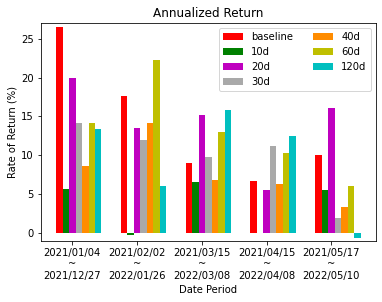

In [14]:

import numpy as np
import matplotlib.pyplot as plt
  
N = len(baseline)
# N = 5
ind = np.arange(N) 
width = 0.1
  
vals_taiex = [x * 100 for x in baseline]
bar1 = plt.bar(ind, vals_taiex, width, color = 'r')
  
vals_10 = [(x - 1) * 100 for x in annualized_return[10]]
bar2 = plt.bar(ind+width, vals_10, width, color='g')
  
vals_20 = [(x - 1) * 100 for x in annualized_return[20]]
bar3 = plt.bar(ind+width*2, vals_20, width, color = 'm')

vals_30 = [(x - 1) * 100 for x in annualized_return[30]]
bar4 = plt.bar(ind+width*3, vals_30, width, color = 'darkgray')

vals_40 = [(x - 1) * 100 for x in annualized_return[40]]
bar5 = plt.bar(ind+width*4, vals_40, width, color = 'darkorange')

vals_60 = [(x - 1) * 100 for x in annualized_return[60]]
bar6 = plt.bar(ind+width*5, vals_60, width, color = 'y')

vals_120 = [(x - 1) * 100 for x in annualized_return[120]]
bar7 = plt.bar(ind+width*6, vals_120, width, color = 'c')
  
plt.xlabel("Date Period")
# plt.xlabel("Year")
plt.ylabel('Rate of Return (%)')
plt.title("Annualized Return")
plt.ylim(-1, 27)
  
plt.xticks(ind+width*2,['2021/01/04\n~\n2021/12/27',
'2021/02/02\n~\n2022/01/26',
'2021/03/15\n~\n2022/03/08',
'2021/04/15\n~\n2022/04/08',
'2021/05/17\n~\n2022/05/10'
])







plt.legend((bar1, bar2, bar3, bar4, bar5, bar6, bar7),
           ('baseline', '10d', '20d', '30d', '40d', '60d', '120d'),
           ncol = 2)
plt.show()





In [15]:
# Average Annualized Return
print('baseline', round(mean(baseline) * 100, 2))
print('10d', round((mean(annualized_return[10]) - 1) * 100, 2))
print('20d', round((mean(annualized_return[20]) - 1) * 100, 2))
print('30d', round((mean(annualized_return[30]) - 1) * 100, 2))
print('40d', round((mean(annualized_return[40]) - 1) * 100, 2))
print('60d', round((mean(annualized_return[60]) - 1) * 100, 2))
print('120d', round((mean(annualized_return[120]) - 1) * 100, 2))

baseline 13.95
10d 3.49
20d 14.01
30d 9.79
40d 7.84
60d 13.14
120d 9.41
